## Imports

In [1]:
from dataset.flow_dataset import MultiModalDataset
import PIL
import matplotlib.pyplot as plt
from mmaction.datasets import build_dataset
from dataset.pipelines.normalise import Normalise
import torch
import torchvision
import os

/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
os.chdir('../../..')

## Function to display image

In [3]:
def imshow(tensor, idx=0):
    plt.imshow(tensor.permute(1, 2, 3, 0)[idx])
    plt.axis('off')

## Multimodal Dataset

In [4]:
train_dataset = MultiModalDataset(ann_file='data/wlasl/train_annotations.txt',
                                  root_dir='data/wlasl/rawframes',
                                  clip_len=32,
                                  resolution=224,
                                  modalities=('rgb', 'flow'),
                                  frame_interval=1,
                                  num_clips=1
                                  )

test_dataset = MultiModalDataset(ann_file='data/wlasl/test_annotations.txt',
                                 root_dir='data/wlasl/rawframes',
                                 clip_len=32,
                                 resolution=224,
                                 modalities=('rgb', 'flow'),
                                 test_mode=True,
                                 frame_interval=1,
                                 num_clips=1
                                 )

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=4,
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          num_workers=4,
                                          pin_memory=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


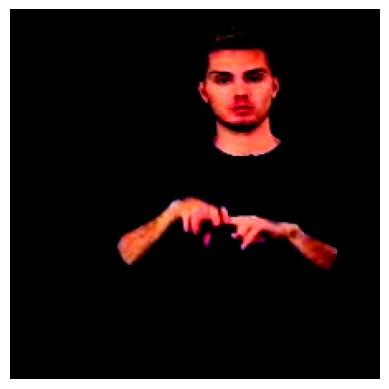

In [5]:
iter_ = iter(train_loader)
batch = next(iter_)
imshow(batch[0][0], 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


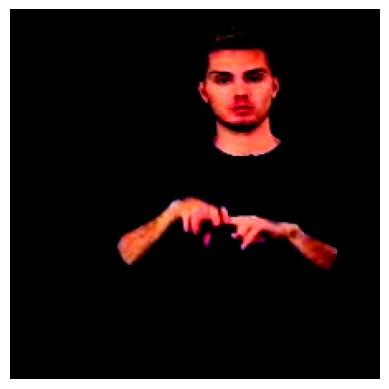

In [6]:
imshow(batch[0][0], 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


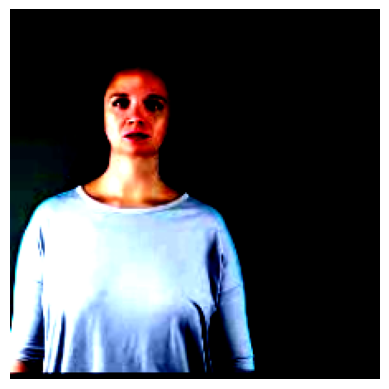

In [14]:
imshow(batch[0][0], 10)

## Finding the mean and std for flow

In [6]:
i=0
r_mean = 0
g_mean = 0
b_mean = 0

r_std = 0
g_std = 0
b_std = 0

In [7]:
batch = next(iter_)

In [8]:
flow = batch[1][0]

In [9]:
flow.shape

torch.Size([3, 32, 224, 224])

In [10]:
while i < len(train_loader):
    batch = next(iter_)
    flow = batch[1][0]

    r_mean += flow[0].mean().item()
    g_mean += flow[1].mean().item()
    b_mean += flow[2].mean().item()

    r_std += flow[0].std().item()
    g_std += flow[1].std().item()
    b_std += flow[2].std().item()

    i+=1

KeyboardInterrupt: 

In [ ]:
i

In [ ]:
r_mean/i

In [ ]:
g_mean/i

In [ ]:
b_mean/i

In [ ]:
r_std/i

In [ ]:
g_std/i

In [ ]:
b_std/i

In [ ]:
normalise = Normalise(mean=[0.9444415, 0.9504853, 0.9530699], std=[0.1113386, 0.1044944, 0.1007349])

In [ ]:
imshow(normalise(batch[1][0]), 9)

In [ ]:
imshow(batch[2][0])

In [ ]:
batch[1].shape

In [ ]:
batch[0].shape

In [ ]:
rgb = batch[0][0]
flow = batch[1][0]
x = torch.cat((rgb, flow), dim=1)
x.shape

In [ ]:
train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(256)),
                                                  torchvision.transforms.RandomResizedCrop(size=(224), scale=(0.4, 1.0)),
                                                  torchvision.transforms.RandomHorizontalFlip(p=0.5)]
                               )

In [ ]:
rgb.shape

In [ ]:
imshow(rgb)

In [ ]:
y = train_transform(x)

In [ ]:
y.shape

In [ ]:
rgb_transformed = y[:, 0:32, :, :]

In [ ]:
flow_transformed = y[:, 32:64, :, :]

In [ ]:
rgb.shape

In [ ]:
imshow(rgb_transformed)

## MMCV Dataset

In [18]:
test_cfg = dict(
        type='RawframeDataset',
        ann_file='data/wlasl/test_annotations.txt',
        data_prefix='data/wlasl/rawframes',
        test_mode=True,
        pipeline=[
            dict(
                    type='SampleFrames',
                    clip_len=32,
                    frame_interval=2,
                    num_clips=1,
                    test_mode=True),
            dict(type='RawFrameDecode'),
            dict(type='Resize', scale=(-1, 256)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_bgr=False),
            dict(type='FormatShape', input_format='NCTHW'),
            dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
            dict(type='ToTensor', keys=['imgs'])
        ])

# Building the datasets
test_dataset = build_dataset(test_cfg)

mmcv_test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                      batch_size=1,
                                      shuffle=False,
                                      num_workers=4,
                                      pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


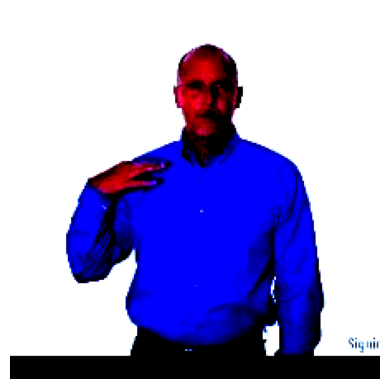

In [19]:
img_iter = iter(mmcv_test_loader)
x = next(img_iter)
mmcv_imgs = x['imgs']
imshow(mmcv_imgs.squeeze(), 0)

In [ ]:
video_iter = iter(mmcv_imgs.squeeze().permute(1,2,3,0))

In [ ]:
plt.imshow(next(video_iter))
plt.axis('off')

In [7]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np

from dataset.flow_dataset import MultiModalDataset
from mmcv_model.mmcv_csn import ResNet3dCSN
from model.multimodal_neck import MultiModalNeck
from model.simple_head import SimpleHead
from model.flow_autoencoder import FlowAutoencoder
from mmcv_model.scheduler import GradualWarmupScheduler
from mmaction.datasets import build_dataset

In [8]:
rgb_backbone = ResNet3dCSN(
    pretrained2d=False,
    # pretrained=None,
    pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)

flow_backbone = ResNet3dCSN(
    pretrained2d=False,
    # pretrained=None,
    pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)

rgb_backbone.init_weights()
flow_backbone.init_weights()

neck = MultiModalNeck()

head = SimpleHead(num_classes=400,
                  in_channels=4096,
                  dropout_ratio=0.5,
                  init_std=0.01)

head.init_weights()

model = FlowAutoencoder(rgb_backbone=rgb_backbone,
                        flow_backbone=flow_backbone,
                        neck=neck,
                        head=head)

In [9]:
x = rgb_backbone(batch[1])

In [10]:
len(x)

5

In [11]:
x[0].shape

torch.Size([1, 64, 32, 112, 112])

In [17]:
x = neck(rgb=x[-1].to('cuda'))

In [20]:
x = head(x.to('device'))

RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, privateuseone device type at start of device string: device